`Setup`

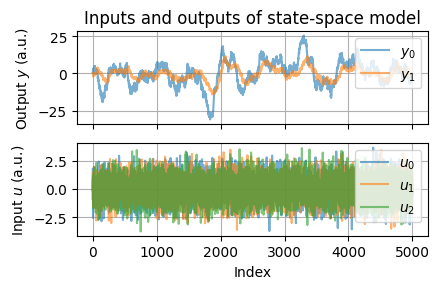

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp
import control as ct

from inter.state_space_e import StateSpace_e
from inter.nfoursid_e import NFourSID_e
from inter.kalman_e import Kalman_e

from inter.control import Utils_e

from sim_settings import SimSettings
sim = SimSettings()

CLOUD = "cloud"
LOCAL = "local"

method = CLOUD

pd.set_option('display.max_columns', None)
np.random.seed(0)  # reproducable results

state_space = StateSpace_e(sim.A, sim.B, sim.C, sim.D)
for _ in range(sim.NUM_TRAINING_DATAPOINTS):
    input_state = np.random.standard_normal((sim.INPUT_DIM, 1))
    noise = np.random.standard_normal((sim.OUTPUT_DIM, 1)) * sim.NOISE_AMPLITUDE
    state_space.step(input_state, noise)

# Plot the I/O data for inspections
fig = plt.figure(figsize=sim.figsize)
state_space.plot_input_output(fig)  # the state-space model can plot its inputs and outputs
fig.tight_layout()


In [3]:
df = state_space.to_dataframe()
# Print the first few rows of the dataframe
print(df.head())

print(state_space.y_column_names)

      $u_0$     $u_1$     $u_2$     $y_0$     $y_1$
0  1.764052  0.400157  0.978738  0.498368  0.226772
1 -0.977278  0.950088 -0.151357  1.250710  0.002683
2  0.144044  1.454274  0.761038  1.362102 -0.248525
3  0.333674  1.494079 -0.205158  2.345503 -0.836026
4 -2.552990  0.653619  0.864436  2.536616 -1.058894
['$y_0$', '$y_1$']


`Local`

In [4]:
if method == LOCAL:

    # Construct the N4SID model
    nfoursid = NFourSID_e(
        state_space.to_dataframe(),  # the state-space model can summarize inputs and outputs as a dataframe
        output_columns=state_space.y_column_names,
        input_columns=state_space.u_column_names,
        num_block_rows=sim.NUM_BLOCK_ROWS
    )

    # Estimate the state-space model
    nfoursid.subspace_identification()
    state_space_identified, covariance_matrix = nfoursid.system_identification(
        rank=sim.ORDER_OF_MODEL_TO_FIT
    )

    # Plot the eigenvalues of the estimated observability matrix
    fig, ax = plt.subplots(figsize=sim.figsize)
    nfoursid.plot_eigenvalues(ax)
    fig.tight_layout()

`Cloud`

In [5]:
if method == CLOUD:

    # Call the cloud-deployment identification algorithm
    io_data = state_space.to_dataframe().to_json(orient="split")

    y_column_names = state_space.y_column_names
    u_column_names = state_space.u_column_names

    request_data = {
        "io_data": io_data,
        "y_column_names": y_column_names,
        "u_column_names": u_column_names,
        "num_block_rows": sim.NUM_BLOCK_ROWS,
        "order_of_model_to_fit": sim.ORDER_OF_MODEL_TO_FIT
    }

    # We can call localhost:8080 for now
    import requests

    # url = "http://localhost:8080/"
    # response = requests.post(url, json=request_data)

    url = "https://nfoursid-bchwt6adfq-km.a.run.app"
    token = sim.TOKEN
    headers = {
        "Authorization": f"Bearer {token}"
    }
    response = requests.post(url, json=request_data, headers=headers)

    if response.status_code == 200:
        data = response.json()
        state_space_identified = StateSpace_e(
            a=np.array(data["a"]),
            b=np.array(data["b"]),
            c=np.array(data["c"]),
            d=np.array(data["d"])
        )
    else:
        print("Error: ", response.status_code)
        print(response.text)



`Eigenvalue Comparison`

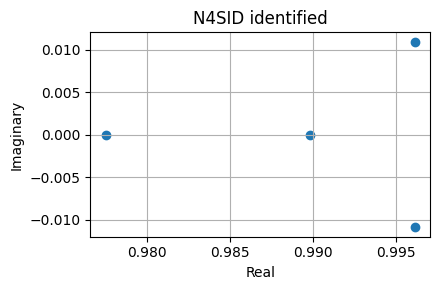

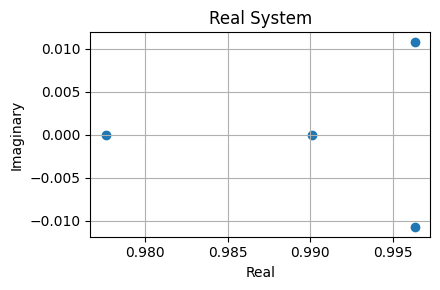

In [6]:
def plot_a_matrix_eigs(ax: plt.Axes, a_matrix: np.ndarray, title: str):
    eigenvalues_system = np.linalg.eigvals(a_matrix)
    ax.scatter(eigenvalues_system.real,eigenvalues_system.imag)
    ax.set_title(title)
    ax.set_xlabel('Real')
    ax.set_ylabel('Imaginary')
    ax.grid(True)

fig, ax = plt.subplots(figsize=(sim.FIGSIZE*1.5, sim.FIGSIZE))
plot_a_matrix_eigs(ax=ax, a_matrix=state_space_identified.a, title="N4SID identified")
eigenvalues_system = np.linalg.eigvals(state_space_identified.a)
fig.tight_layout()

fig, ax = plt.subplots(figsize=(sim.FIGSIZE*1.5, sim.FIGSIZE))
plot_a_matrix_eigs(ax=ax, a_matrix=sim.A, title="Real System")
eigenvalues_system = np.linalg.eigvals(state_space_identified.a)
fig.tight_layout()


`SymPy Analytics`

In [ ]:
sp_A = sim.sp_A
sp_B = sim.sp_B
sp_C = sim.sp_C
sp_D = sim.sp_D

sp_z = sp.symbols('z')
sp_I = sp.eye(sp.Rational(sp_A.shape[0]))

sp_zI_minus_A = sp_z*sp_I - sp_A
sp_zI_minus_A_inv = sp_zI_minus_A.inv()

tf_sym = sp_C * sp_zI_minus_A_inv * sp_B + sp_D

# char_eq = sI_A_inv.det()
# poles = sp.solve(char_eq, z)

for input in range(sim.INPUT_DIM):
    for output in range(sim.OUTPUT_DIM):

        tf_single = tf_sym[output, input]
        sp.pprint(tf_single.simplify())

        # print("\n\n\n")


`Control Analytics`

In [ ]:
a = state_space.a
b = state_space.b
c = state_space.c
d = state_space.d
dt = 0.1

ss = ct.StateSpace(a, b, c, d, dt=dt)
tf = ct.ss2tf(ss)


for input in range(sim.INPUT_DIM):
    for output in range(sim.OUTPUT_DIM):

        tf_single = tf[output, input]

        print(tf_single)

        pzm = ct.pole_zero_map(tf_single)
        poles = pzm.poles
        fix, ax = plt.subplots(figsize=sim.figsize)
        ax.scatter([z.real for z in poles], [z.imag for z in poles], color='red', label='Zeros')

# ct.bode(tf1, dB=True)
# ct.nyquist_plot(tf1)
# ct.pole_zero_plot(tf1)



`Kalman Filtering`

In [ ]:
kalman = Kalman_e(state_space_identified, covariance_matrix)

state_space = StateSpace_e(sim.A, sim.B, sim.C, sim.D)  # new data for the test-set

for _ in range(sim.NUM_TEST_DATAPOINTS):  # make a test-set
    input_state = np.random.standard_normal((sim.INPUT_DIM, 1))
    noise = np.random.standard_normal((sim.OUTPUT_DIM, 1)) * sim.NOISE_AMPLITUDE

    y = state_space.step(input_state, noise)  # generate test-set
    kalman.step(y, input_state)  # the Kalman filter sees the output and input, but not the actual internal state


# Plot the filtered state of the Kalman filter using Kalman.plot_filtered.
# The top graph shows the output of the Kalman filter against the filtered states.
#       Expected standard deviation is plotted as error bars.
# The bottom graph zooms in on the filtering error.
#       In this plot, expected standard deviation is plotted as dotted lines.
fig = plt.figure(figsize=sim.figsize)
kalman.plot_filtered(fig)
fig.tight_layout()


# The Kalman filter also provides an prediction of the next internal state.
# Based on the predicted internal state and the fitted model,
#   it is possible to estimate the output of the next timestep.
# It is necessary to correct the output prediction with the known input of the next timestep,
#   using the estimated system matrix Kalman.state_space.d.
# This is not a limitation, because the inputs and estimated system matrices are known to the experimenter.
# The predicted outputs can be plotted using Kalman.plot_predicted, like the previous plot of the filtered states.
# The one-step ahead predicted output, assuming no further inputs,
#   is shown as a star with expected standard deviation as error bars.
fig = plt.figure(figsize=sim.figsize)
kalman.plot_predicted(fig)
fig.tight_layout()

# We can access the output data of the Kalman filter using Kalman.to_dataframe().
# This returns a dataframe for all output columns containing
#       The actual output, which was given to the Kalman filter using Kalman.step,
#       The filtered output state,
#       The next predicted state, assuming no further inputs,
#       The next predicted state, adjusted ex-post with the next input.
kalman.to_dataframe()